# Accelerated Alternating Projection

Paper: https://arxiv.org/pdf/1711.05519.pdf

Matlab Script: https://github.com/caesarcai/AccAltProj_for_RPCA/blob/master/AccAltProj.m

Full Repository: https://github.com/caesarcai/AccAltProj_for_RPCA 

In [8]:
import numpy as np
from numpy import linalg as LA
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.optim import Adam
from torch.optim import SGD
import math
import scipy.stats as stats

from helper import *

torch.set_printoptions(precision=3, sci_mode=True)

## Unrolled version

In [9]:
## ======================== Learned AccAltProj model ========================
## recover low-rank matrix L from M = L + S

class InitStage(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, M0, r):
        m, n = M0.shape
        norm_of_M0 = torch.linalg.norm(M0)
        beta = 1/(2 * np.power(m * n, 1/4))
        beta_init = 4 * beta
        zeta = beta_init * torch.linalg.norm(M0, 2)
        S = thres(M0, zeta, hard=False)
        U, Sigma, V = torch.linalg.svd(M0 - S, full_matrices=False)
        U, Sigma, V = U[:,:r], Sigma[:r], V.t()[:, :r]
        L = U @ torch.diag(Sigma) @ V.t()
        zeta = beta * Sigma[0]
        S = M0 - L
        S = thres(S, zeta, hard=False)
        return S, L, U, V, beta, norm_of_M0

class ProjStage(nn.Module):
    def __init__(self, gamma, lay):
        super().__init__()
        self.gamma = gamma
        self.lay = lay
    def forward(self, M0, S, U, V, r, beta):
        ## Update L
        Z = M0 - S
        Q1, R1 = torch.linalg.qr(Z.t() @ U - V @ ((Z @ V).t() @ U)) ## reduced QR
        Q2, R2 = torch.linalg.qr(Z @ V - U @ (U.t() @ Z @ V)) ## reduced QR
        A = torch.cat((torch.cat((U.t() @ Z @ V, R1.t()), 1), 
                        torch.cat((R2, torch.zeros(R2.shape)), 1)), 0) ## A is 2r x 2r matrix
        Um, Sm, Vm = torch.linalg.svd(A, full_matrices=False)
        U = torch.cat((U, Q2), 1) @ Um[:,:r]
        V = torch.cat((V, Q1), 1) @ Vm.t()[:,:r]
        L = U @ torch.diag(Sm[:r]) @ V.t()
        ## Update S
        zeta = beta * (Sm[r] + torch.pow(self.gamma, self.lay) * Sm[0])
        S = M0 - L
        S = thres(S, zeta, hard=False)
        return S, L, U, V

class LearnedAAP(nn.Module):
    def __init__(self, max_iter):
        super().__init__()
        self.max_iter = max_iter
        self.gamma = nn.Parameter(torch.tensor(0.7))
        #self.gamma = torch.tensor(0.7)
        self.beta = nn.Parameter(torch.tensor(0.03))

        ## Stack layers
        self.layer = [InitStage()]
        for t in range(max_iter):
            #self.layer.append(ProjStage(gamma = nn.Parameter(torch.pow(self.gamma.clone().detach(), t + 1).requires_grad_(True))))
            #self.layer.append(ProjStage(gamma = nn.Parameter(self.gamma.clone().detach().requires_grad_(True))))
            self.layer.append(ProjStage(self.gamma, t+1))
        self.layers = nn.Sequential(*self.layer)
        ## Track loss
        self.err = np.zeros(max_iter + 1)

    def forward(self, M0, r):
        lay_init = self.layers[0]
        S, L, U, V, beta, norm_of_M0 = lay_init(M0, r)
        for t in range(1, self.max_iter + 1):
            lay = self.layers[t]
            S, L, U, V = lay(M0, S, U, V, r, self.beta)
            self.err[t] = torch.linalg.norm(M0 - L - S)/ norm_of_M0
        return L, S

## The Pipeline

### Scenario 1:
**alpha = 0.1** (low sparsity), **c = 1**, r = 2, dimension = 250x250

gamma=6.829e-01; beta=1.344e-02

***results: Performance better than AccAltproj but not IRCUR for L after unrolling. But L_hat obtained is slightly worse as compared to the L_hat from network trained on accaltproj.***

In [10]:
## ======================== 0. set constants ========================
d1 = 250                   # num. of rows
d2 = 250                   # num. of columns
max_iter = 40              # num. of layers trained
alpha_true = 0.1
c_true = 1
r = 2
dataset_size = 1000

## ======================== 1. generate data ========================
train, test =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 900
test dataset size: 100


#### Training

In [11]:
## ======================== 2. estimations by classical ========================
## ======================== USING IRCUR AS EST ========================
train_est = []
for i, (L_true, S_true, M_true) in enumerate(train):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    train_est.append((L0, S0, M_true))

In [12]:
## ======================== 3. train unrolled network with estimated data ========================
net, params_bftrain, params_aftrain, l0_norm_of_S_Shat = train_nn(LearnedAAP(max_iter), r \
                                                                    , lr=2e-04, weight_decay=0 \
                                                                    , nepochs=100, dataset=train_est)

[Parameter containing:
tensor(6.982e-01, requires_grad=True), Parameter containing:
tensor(2.823e-02, requires_grad=True)]
Epoch 1/100 at cost=1.2815310583391692e-05
[Parameter containing:
tensor(6.966e-01, requires_grad=True), Parameter containing:
tensor(2.652e-02, requires_grad=True)]
Epoch 2/100 at cost=1.2121651707275305e-05
[Parameter containing:
tensor(6.950e-01, requires_grad=True), Parameter containing:
tensor(2.489e-02, requires_grad=True)]
Epoch 3/100 at cost=1.1603576240304392e-05
[Parameter containing:
tensor(6.936e-01, requires_grad=True), Parameter containing:
tensor(2.338e-02, requires_grad=True)]
Epoch 4/100 at cost=1.1309133697068319e-05
[Parameter containing:
tensor(6.923e-01, requires_grad=True), Parameter containing:
tensor(2.200e-02, requires_grad=True)]
Epoch 5/100 at cost=1.1068420462834183e-05
[Parameter containing:
tensor(6.912e-01, requires_grad=True), Parameter containing:
tensor(2.074e-02, requires_grad=True)]
Epoch 6/100 at cost=1.0887164535233751e-05
[Par

#### Evaluating unrolled network on train dataset

In [13]:
out_bftrain, out_hat = get_net_outputs(net, LearnedAAP(max_iter), r, train)
out_accaltproj = []
for i, (L_true, S_true, M_true) in enumerate(train):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj.append((L0, S0))

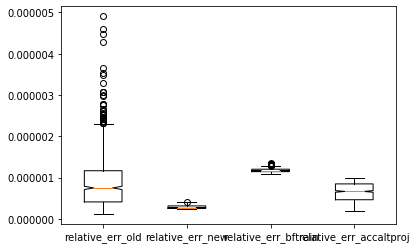

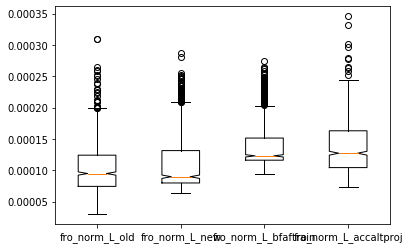

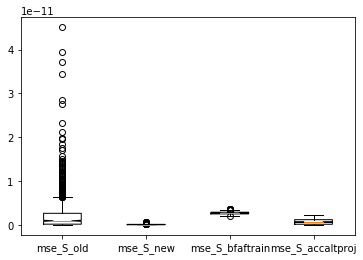

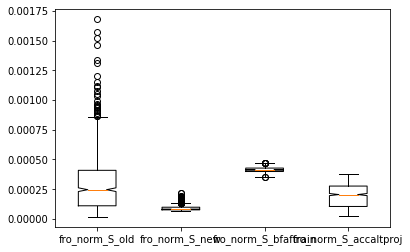

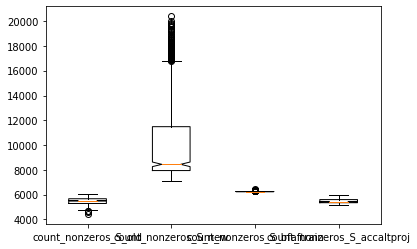

In [241]:
metrics = get_metrics(train, [x[:2] for x in train_est], out_bftrain, out_hat)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(train, out_accaltproj, out_bftrain, out_hat).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [214]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  9.49688086779017e-123
fro_norm_L_new, fro_norm_L_old:  0.9999949576369913
mse_S_new, mse_S_old:  6.935270337701638e-50
fro_norm_S_new, fro_norm_S_old:  5.173084055827057e-101
count_nonzeros_S_new, count_nonzeros_S_old:  1.0

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  7.624333677753067e-252
fro_norm_L_new, fro_norm_L_accaltproj:  4.407030185598129e-32
mse_S_new, mse_S_accaltproj:  2.5514570749302545e-132
fro_norm_S_new, fro_norm_S_accaltproj:  9.978238975181704e-129
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  1.0

relative_err_new, relative_err_bftrain:  0.0
fro_norm_L_new, fro_norm_L_bftrain:  3.286178891364535e-43
mse_S_new, mse_S_bftrain:  0.0
fro_norm_S_new, fro_norm_S_bftrain:  0.0
count_nonzeros_S_new, count_nonzeros_S_bftrain:  1.0


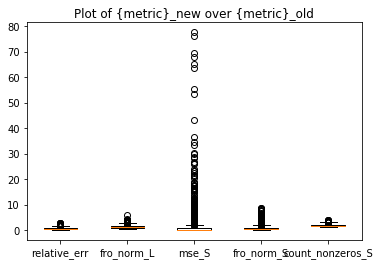

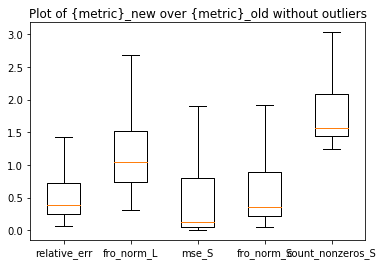

relative_err: 47/900 outliers
fro_norm_L: 52/900 outliers
mse_S: 169/900 outliers
fro_norm_S: 133/900 outliers
count_nonzeros_S: 93/900 outliers


In [215]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [218]:
print("P-values from test of mean with H1: _new/_old < 1")
print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
*Note: values are log-transformed before deriving p-values 

relative_err:  2.1761107039277472e-175
fro_norm_L:  0.999998415330852
mse_S:  8.1589987098630605e-81
fro_norm_S:  8.159846736187433e-81
count_nonzeros_S:  1.0


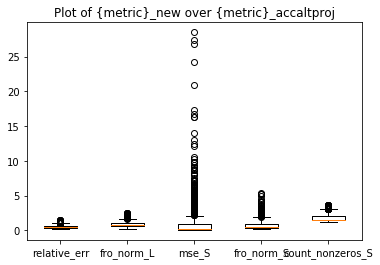

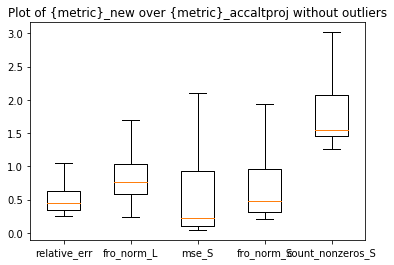

relative_err: 37/900 outliers
fro_norm_L: 61/900 outliers
mse_S: 135/900 outliers
fro_norm_S: 84/900 outliers
count_nonzeros_S: 95/900 outliers


In [242]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [243]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  2.3052e-319
fro_norm_L:  8.447761017677594e-17
mse_S:  0.9926468715137358
fro_norm_S:  2.8038702260788212e-15
count_nonzeros_S:  1.0


#### Evaluating unrolled network on test dataset

In [25]:
out_bftrain_ontest, out_hat_ontest = get_net_outputs(net, LearnedAAP(max_iter), r, test)
out_accaltproj_ontest = []
out_ircur_ontest = []
for (L_true, S_true, M_true) in test:
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), 40)
    out_accaltproj_ontest.append((L0, S0))
    loss0, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, 40)
    out_ircur_ontest.append((L0, S0))

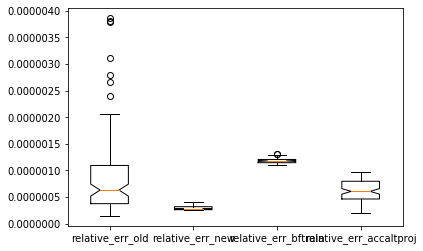

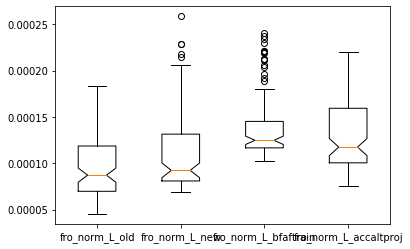

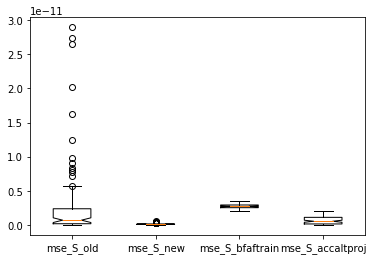

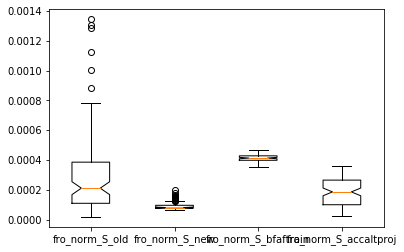

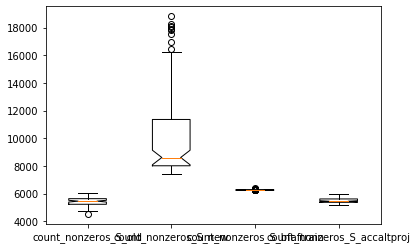

In [224]:
metrics = get_metrics(test, out_ircur_ontest, out_bftrain_ontest, out_hat_ontest)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(test, out_accaltproj_ontest, out_bftrain_ontest, out_hat_ontest).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [225]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  4.170253974257392e-12
fro_norm_L_new, fro_norm_L_old:  0.9966670274088407
mse_S_new, mse_S_old:  2.7634675512498714e-06
fro_norm_S_new, fro_norm_S_old:  6.939026810690753e-11
count_nonzeros_S_new, count_nonzeros_S_old:  1.0

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.6608691383203705e-27
fro_norm_L_new, fro_norm_L_accaltproj:  0.004287184012096304
mse_S_new, mse_S_accaltproj:  4.985219294545904e-15
fro_norm_S_new, fro_norm_S_accaltproj:  1.9337575617972858e-14
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  1.0

relative_err_new, relative_err_bftrain:  1.5290450245960524e-119
fro_norm_L_new, fro_norm_L_bftrain:  1.5066976886188728e-06
mse_S_new, mse_S_bftrain:  2.806278367937044e-94
fro_norm_S_new, fro_norm_S_bftrain:  5.974702413422426e-99
count_nonzeros_S_new, count_nonzeros_S_bftrain:  1.0


<p style="color:blue;"> Performance better than AccAltproj but not IRCUR for L. </p>

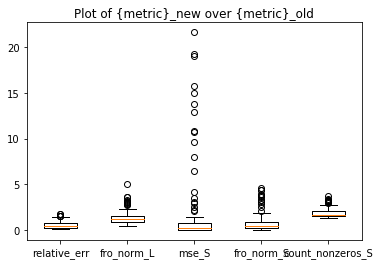

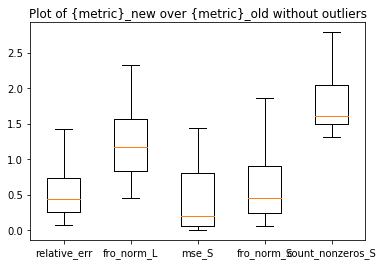

relative_err: 6/100 outliers
fro_norm_L: 11/100 outliers
mse_S: 19/100 outliers
fro_norm_S: 13/100 outliers
count_nonzeros_S: 10/100 outliers


In [233]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [234]:
print("P-values from test of mean with H1: _new/_old < 1")
print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
*Note: values are log-transformed before deriving p-values 

relative_err:  2.0256379790002606e-18
fro_norm_L:  0.9986021439646426
mse_S:  8.562864893612974e-10
fro_norm_S:  8.562956624903341e-10
count_nonzeros_S:  1.0


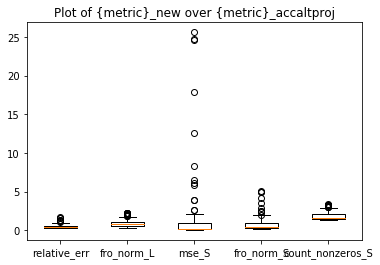

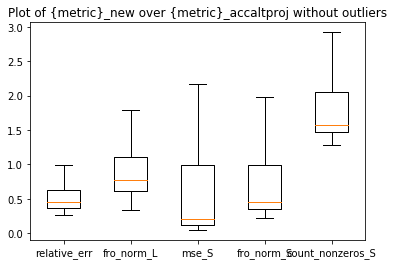

relative_err: 8/100 outliers
fro_norm_L: 11/100 outliers
mse_S: 13/100 outliers
fro_norm_S: 10/100 outliers
count_nonzeros_S: 10/100 outliers


In [235]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [240]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
*Note: values are log-transformed before deriving p-values 

relative_err:  1.0090339373672626e-29
fro_norm_L:  0.0003403531129584047
mse_S:  2.2670345943571976e-09
fro_norm_S:  2.2670593905945553e-09
count_nonzeros_S:  1.0


<p style="color:blue;"> Performance better than AccAltproj but not IRCUR for L. </p>

### Scenario 2:
**alpha = 0.3** (higher sparsity), **c = 1**, r = 2, dimension = 250x250

gamma=6.834e-01; beta=9.326e-03

***results: metrics from unrolled slightly better than ircur, and better than accaltproj (except for L, which has about no difference)***

In [52]:
## ======================== 0. set constants ========================
d1 = 250                   # num. of rows
d2 = 250                   # num. of columns
max_iter = 40              # num. of layers trained
alpha_true = 0.3
c_true = 1
r = 2
dataset_size = 1000

## ======================== 1. generate data ========================
train2, test2 =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 900
test dataset size: 100


#### Training

In [53]:
## ======================== 2. estimations by classical ========================
train_est2 = []
for i, (L_true, S_true, M_true) in enumerate(train2):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    train_est2.append((L0, S0, M_true))

In [54]:
## ======================== 3. train unrolled network with estimated data ========================
net2, params_bftrain2, params_aftrain2, l0_norm_of_S_Shat2 = train_nn(LearnedAAP(max_iter), r \
                                                                    , lr=2e-04, weight_decay=0 \
                                                                    , nepochs=100, dataset=train_est2)

[Parameter containing:
tensor(6.982e-01, requires_grad=True), Parameter containing:
tensor(2.821e-02, requires_grad=True)]
Epoch 1/100 at cost=9.35936168389162e-06
[Parameter containing:
tensor(6.965e-01, requires_grad=True), Parameter containing:
tensor(2.645e-02, requires_grad=True)]
Epoch 2/100 at cost=7.6220107985136565e-06
[Parameter containing:
tensor(6.948e-01, requires_grad=True), Parameter containing:
tensor(2.476e-02, requires_grad=True)]
Epoch 3/100 at cost=6.705219675495755e-06
[Parameter containing:
tensor(6.933e-01, requires_grad=True), Parameter containing:
tensor(2.316e-02, requires_grad=True)]
Epoch 4/100 at cost=6.799808033974841e-06
[Parameter containing:
tensor(6.920e-01, requires_grad=True), Parameter containing:
tensor(2.166e-02, requires_grad=True)]
Epoch 5/100 at cost=6.182011929922737e-06
[Parameter containing:
tensor(6.908e-01, requires_grad=True), Parameter containing:
tensor(2.026e-02, requires_grad=True)]
Epoch 6/100 at cost=5.6421858971589245e-06
[Paramete

#### Evaluating unrolled network on train dataset

In [55]:
out_bftrain2, out_hat2 = get_net_outputs(net2, LearnedAAP(max_iter), r, train2)
out_accaltproj2 = []
for i, (L_true, S_true, M_true) in enumerate(train2):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj2.append((L0, S0))

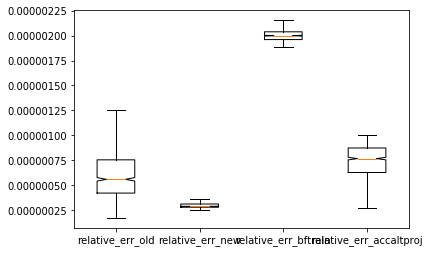

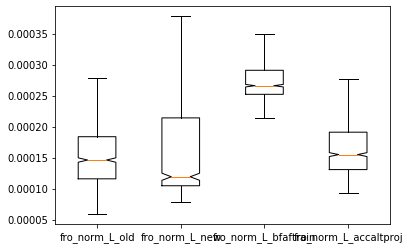

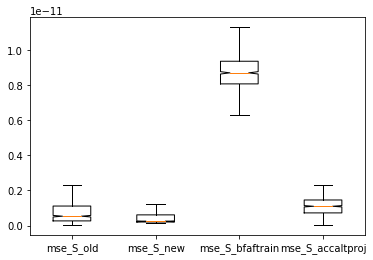

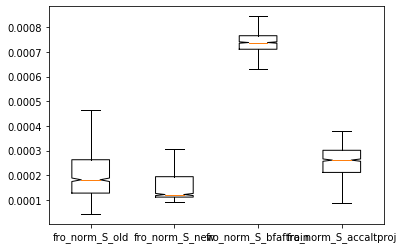

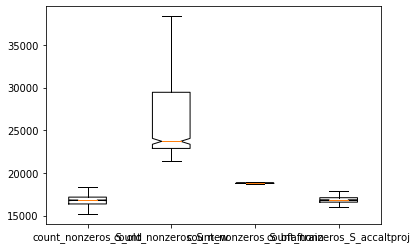

In [179]:
metrics = get_metrics(train2, [x[:2] for x in train_est2], out_bftrain2, out_hat2)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(train2, out_accaltproj2, out_bftrain2, out_hat2).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [186]:
print("P-values from test of mean with H1: _new < _old")
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

print("*Note: values are log-transformed before deriving p-values")
print()
print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
*Note: values are log-transformed before deriving p-values

relative_err_new, relative_err_old:  2.6839958024861356e-229
fro_norm_L_new, fro_norm_L_old:  0.0010738100695241815
mse_S_new, mse_S_old:  1.019291975192183e-11
fro_norm_S_new, fro_norm_S_old:  1.0193854453660873e-11
count_nonzeros_S_new, count_nonzeros_S_old:  1.0

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  0.0
fro_norm_L_new, fro_norm_L_accaltproj:  0.35576641737030945
mse_S_new, mse_S_accaltproj:  3.708508606742054e-61
fro_norm_S_new, fro_norm_S_accaltproj:  3.71040595461618e-61
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  1.0

relative_err_new, relative_err_bftrain:  0.0
fro_norm_L_new, fro_norm_L_bftrain:  1.0570386431974202e-154
mse_S_new, mse_S_bftrain:  0.0
fro_norm_S_new, fro_norm_S_bftrain:  0.0
count_nonzeros_S_new, count_nonzeros_S_bftrain:  1.0


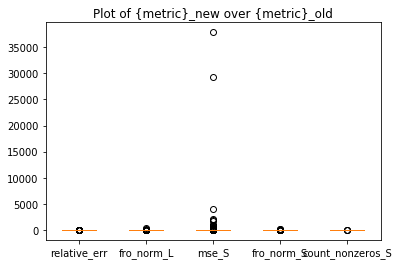

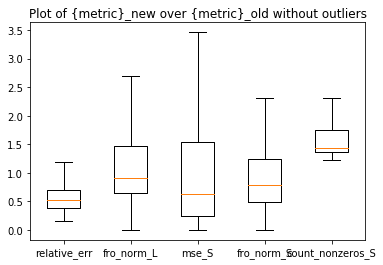

relative_err: 24/900 outliers
fro_norm_L: 73/900 outliers
mse_S: 99/900 outliers
fro_norm_S: 70/900 outliers
count_nonzeros_S: 3/900 outliers


In [187]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [188]:
print("P-values from test of mean with H1: _new/_old < 1")
print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
*Note: values are log-transformed before deriving p-values 

relative_err:  2.6839112677931422e-229
fro_norm_L:  0.0010738097066823543
mse_S:  1.0192918218849908e-11
fro_norm_S:  1.0193877073717746e-11
count_nonzeros_S:  1.0


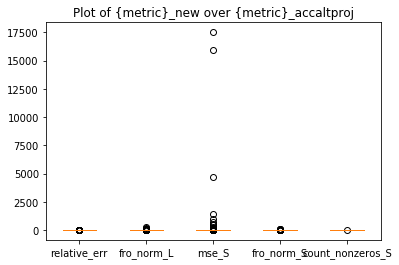

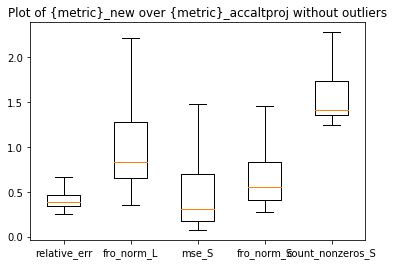

relative_err: 46/900 outliers
fro_norm_L: 68/900 outliers
mse_S: 103/900 outliers
fro_norm_S: 70/900 outliers
count_nonzeros_S: 1/900 outliers


In [192]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [193]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
*Note: values are log-transformed before deriving p-values 

relative_err:  0.0
fro_norm_L:  0.3557663228860387
mse_S:  3.708501559951663e-61
fro_norm_S:  3.7103962888368354e-61
count_nonzeros_S:  1.0


#### Evaluating unrolled network on test dataset

In [62]:
out_bftrain_ontest2, out_hat_ontest2 = get_net_outputs(net2, LearnedAAP(max_iter), r, test2)
out_accaltproj_ontest2 = []
out_ircur_ontest2 = []
for (L_true, S_true, M_true) in test2:
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), 40)
    out_accaltproj_ontest2.append((L0, S0))
    loss0, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, 40)
    out_ircur_ontest2.append((L0, S0))

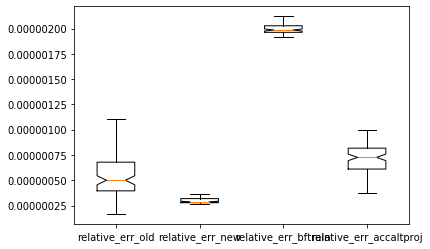

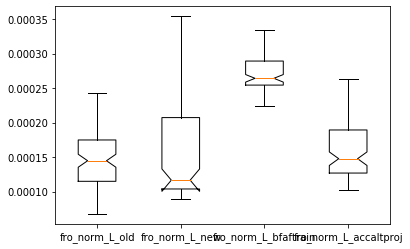

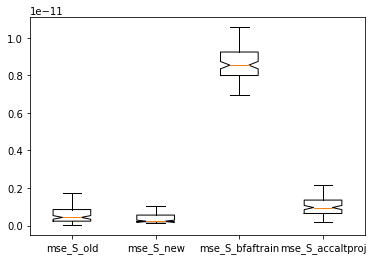

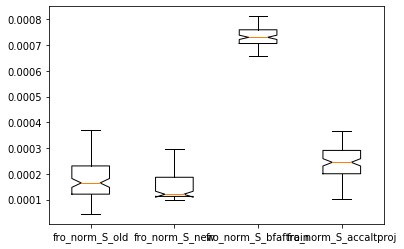

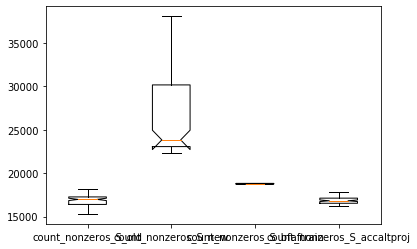

In [199]:
metrics = get_metrics(test2, out_ircur_ontest2, out_bftrain_ontest2, out_hat_ontest2)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(test2, out_accaltproj_ontest2, out_bftrain_ontest2, out_hat_ontest2).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [201]:
print("P-values from test of mean with H1: _new < _old")
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

print("*Note: values are log-transformed before deriving p-values")
print()
print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
*Note: values are log-transformed before deriving p-values

relative_err_new, relative_err_old:  1.5205079299397916e-24
fro_norm_L_new, fro_norm_L_old:  0.3666948957956574
mse_S_new, mse_S_old:  0.12328360684434336
fro_norm_S_new, fro_norm_S_old:  0.12328438896537841
count_nonzeros_S_new, count_nonzeros_S_old:  1.0

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  2.873730456354155e-57
fro_norm_L_new, fro_norm_L_accaltproj:  0.5619022450413571
mse_S_new, mse_S_accaltproj:  4.313285059667535e-06
fro_norm_S_new, fro_norm_S_accaltproj:  4.313442402654308e-06
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  1.0

relative_err_new, relative_err_bftrain:  1.682631242876717e-142
fro_norm_L_new, fro_norm_L_bftrain:  1.7173761632774663e-22
mse_S_new, mse_S_bftrain:  1.1710779062978988e-50
fro_norm_S_new, fro_norm_S_bftrain:  1.1709826636315397e-50
count_nonzeros_S_new, count_nonzeros_S_bftrain:  

<p style="color:blue;"> Unrolled have slight improvement over ircur for both L and S, and statistically significant improvement over accaltproj for all except L. </p>

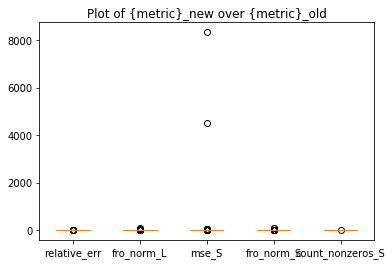

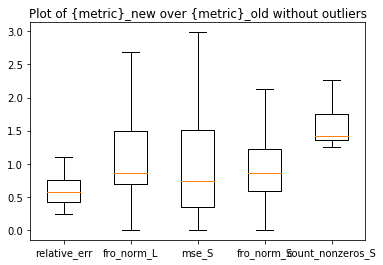

relative_err: 5/100 outliers
fro_norm_L: 9/100 outliers
mse_S: 13/100 outliers
fro_norm_S: 9/100 outliers
count_nonzeros_S: 1/100 outliers


In [202]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [204]:
print("P-values from test of mean with H1: _new/_old < 1")
print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
*Note: values are log-transformed before deriving p-values 

relative_err:  1.5205026600816978e-24
fro_norm_L:  0.3666949061291507
mse_S:  0.12328366606575966
fro_norm_S:  0.12328442751684263
count_nonzeros_S:  1.0


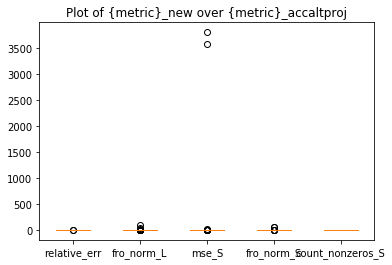

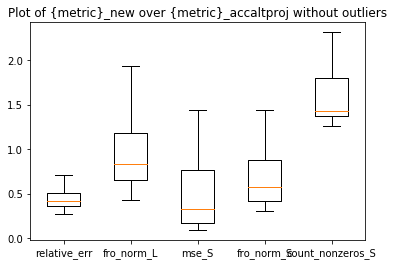

relative_err: 2/100 outliers
fro_norm_L: 11/100 outliers
mse_S: 9/100 outliers
fro_norm_S: 6/100 outliers
count_nonzeros_S: 0/100 outliers


In [205]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [212]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
*Note: values are log-transformed before deriving p-values 

relative_err:  2.8737502803291835e-57
fro_norm_L:  0.5619022656210222
mse_S:  4.313300183980117e-06
fro_norm_S:  4.313443811873762e-06
count_nonzeros_S:  1.0


<p style="color:blue;"> Performance better than AccAltproj. </p>

### Scenario 3:
**alpha = 0.01** (lower sparsity), **c = 1**, r = 2, dimension = 250x250

gamma=6.865e-01; beta=1.545e-02

***result: Same as the case when trained on accaltproj, S from unrolled isn't as good as accaltproj, but is better than ircur. L from unrolled isn't as good as ircur but better than accaltproj.***

In [69]:
## ======================== 0. set constants ========================
d1 = 250                   # num. of rows
d2 = 250                   # num. of columns
max_iter = 40              # num. of layers trained
alpha_true = 0.01
c_true = 1
r = 2
dataset_size = 1000

## ======================== 1. generate data ========================
train3, test3 =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 900
test dataset size: 100


#### Training

In [70]:
## ======================== 2. estimations by classical ========================
train_est3 = []
for i, (L_true, S_true, M_true) in enumerate(train3):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    train_est3.append((L0, S0, M_true))

In [71]:
## ======================== 3. train unrolled network with estimated data ========================
net3, params_bftrain3, params_aftrain3, l0_norm_of_S_Shat3 = train_nn(LearnedAAP(max_iter), r \
                                                                    , lr=2e-04, weight_decay=0 \
                                                                    , nepochs=100, dataset=train_est3)

[Parameter containing:
tensor(6.988e-01, requires_grad=True), Parameter containing:
tensor(2.875e-02, requires_grad=True)]
Epoch 1/100 at cost=9.780174877960235e-05
[Parameter containing:
tensor(6.977e-01, requires_grad=True), Parameter containing:
tensor(2.774e-02, requires_grad=True)]
Epoch 2/100 at cost=9.77733579929918e-05
[Parameter containing:
tensor(6.968e-01, requires_grad=True), Parameter containing:
tensor(2.677e-02, requires_grad=True)]
Epoch 3/100 at cost=9.765864524524659e-05
[Parameter containing:
tensor(6.959e-01, requires_grad=True), Parameter containing:
tensor(2.585e-02, requires_grad=True)]
Epoch 4/100 at cost=9.77812524070032e-05
[Parameter containing:
tensor(6.951e-01, requires_grad=True), Parameter containing:
tensor(2.498e-02, requires_grad=True)]
Epoch 5/100 at cost=9.785793372429907e-05
[Parameter containing:
tensor(6.943e-01, requires_grad=True), Parameter containing:
tensor(2.414e-02, requires_grad=True)]
Epoch 6/100 at cost=9.767612937139347e-05
[Parameter c

#### Evaluating unrolled network on train dataset

In [72]:
out_bftrain3, out_hat3 = get_net_outputs(net3, LearnedAAP(max_iter), r, train3)
out_accaltproj3 = []
for i, (L_true, S_true, M_true) in enumerate(train3):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj3.append((L0, S0))

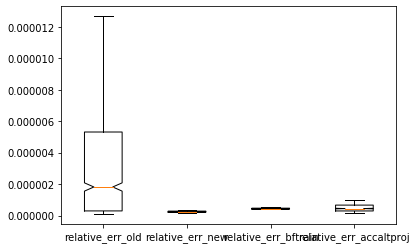

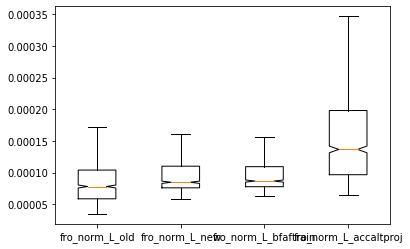

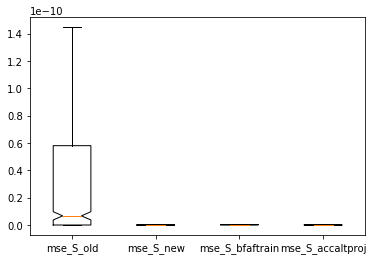

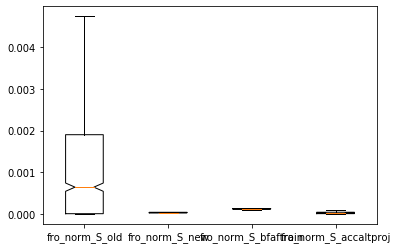

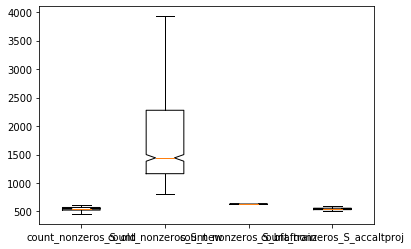

In [174]:
metrics = get_metrics(train3, [x[:2] for x in train_est3], out_bftrain3, out_hat3)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(train3, out_accaltproj3, out_bftrain3, out_hat3).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [175]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  4.5977938170420406e-70
fro_norm_L_new, fro_norm_L_old:  0.9999999999999996
mse_S_new, mse_S_old:  3.583455199422861e-18
fro_norm_S_new, fro_norm_S_old:  1.0308072956022177e-70
count_nonzeros_S_new, count_nonzeros_S_old:  1.0

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  3.628252971890194e-143
fro_norm_L_new, fro_norm_L_accaltproj:  5.358269714888182e-91
mse_S_new, mse_S_accaltproj:  9.741641887001009e-20
fro_norm_S_new, fro_norm_S_accaltproj:  3.610620166137197e-06
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  1.0

relative_err_new, relative_err_bftrain:  0.0
fro_norm_L_new, fro_norm_L_bftrain:  0.2335813356360335
mse_S_new, mse_S_bftrain:  0.0
fro_norm_S_new, fro_norm_S_bftrain:  0.0
count_nonzeros_S_new, count_nonzeros_S_bftrain:  1.0


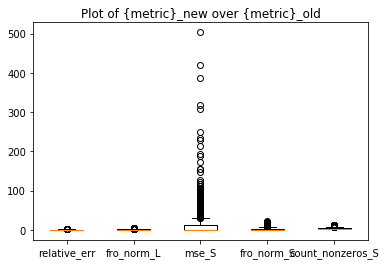

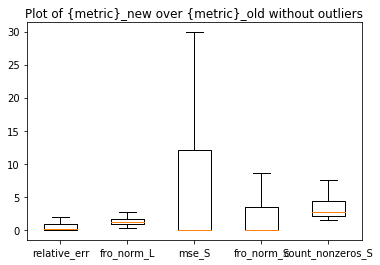

relative_err: 27/900 outliers
fro_norm_L: 33/900 outliers
mse_S: 129/900 outliers
fro_norm_S: 43/900 outliers
count_nonzeros_S: 101/900 outliers


In [138]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [141]:
print("P-values from test of mean with H1: _new/_old < 1")
print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
*Note: values are log-transformed before deriving p-values 

relative_err:  4.2404488902719077e-157
fro_norm_L:  1.0
mse_S:  1.1457480650204985e-80
fro_norm_S:  1.1457355887022382e-80
count_nonzeros_S:  1.0


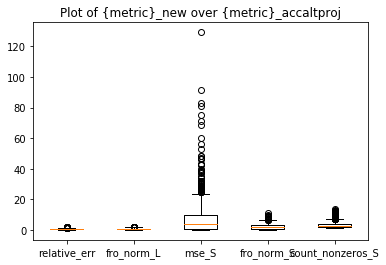

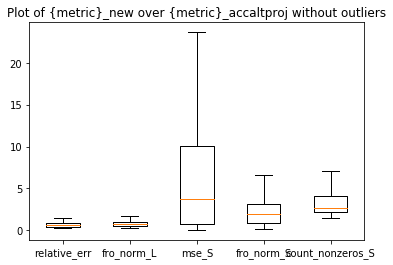

relative_err: 13/900 outliers
fro_norm_L: 31/900 outliers
mse_S: 63/900 outliers
fro_norm_S: 15/900 outliers
count_nonzeros_S: 114/900 outliers


In [176]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [177]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.4548453413291998e-165
fro_norm_L:  3.38029689580205e-72
mse_S:  1.0
fro_norm_S:  1.0
count_nonzeros_S:  1.0


#### Evaluating unrolled network on test dataset

In [79]:
out_bftrain_ontest3, out_hat_ontest3 = get_net_outputs(net3, LearnedAAP(max_iter), r, test3)
out_accaltproj_ontest3 = []
out_ircur_ontest3 = []
for (L_true, S_true, M_true) in test3:
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), 40)
    out_accaltproj_ontest3.append((L0, S0))
    loss0, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, 40)
    out_ircur_ontest3.append((L0, S0))

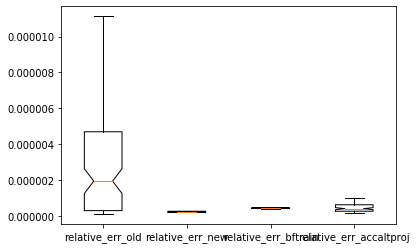

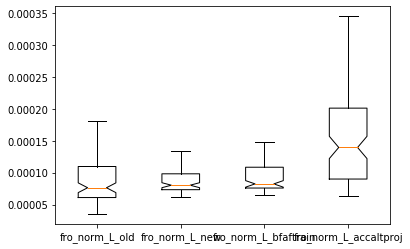

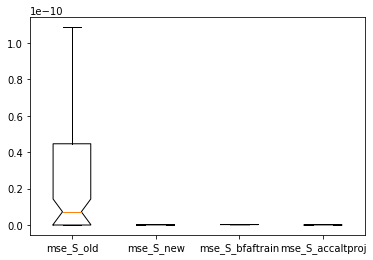

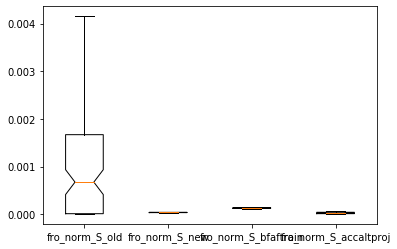

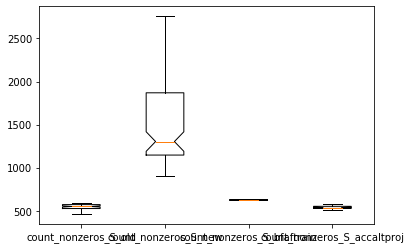

In [150]:
metrics = get_metrics(test3, out_ircur_ontest3, out_bftrain_ontest3, out_hat_ontest3)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(test3, out_accaltproj_ontest3, out_bftrain_ontest3, out_hat_ontest3).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [152]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  1.7441260191079827e-08
fro_norm_L_new, fro_norm_L_old:  0.7237129814816099
mse_S_new, mse_S_old:  0.00117777047483633
fro_norm_S_new, fro_norm_S_old:  2.1074229482836713e-08
count_nonzeros_S_new, count_nonzeros_S_old:  1.0

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.6513507379375097e-17
fro_norm_L_new, fro_norm_L_accaltproj:  1.9922181233107016e-14
mse_S_new, mse_S_accaltproj:  0.05841262812254147
fro_norm_S_new, fro_norm_S_accaltproj:  0.7524469399924598
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  1.0

relative_err_new, relative_err_bftrain:  4.638954384827255e-49
fro_norm_L_new, fro_norm_L_bftrain:  0.08766330210964061
mse_S_new, mse_S_bftrain:  6.790657477129238e-89
fro_norm_S_new, fro_norm_S_bftrain:  1.4517557178427332e-85
count_nonzeros_S_new, count_nonzeros_S_bftrain:  0.9999999999999998


<p style="color:blue;"> L from unrolled is better than from AccAltproj but not IRCUR. S from unrolled is better than IRCUR but not AccAltproj. </p>

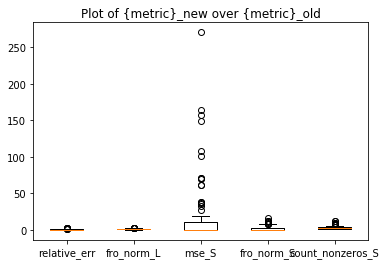

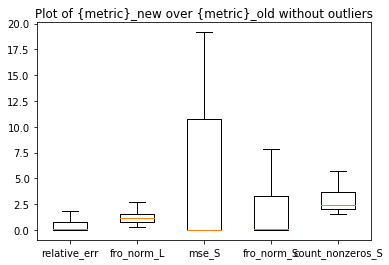

relative_err: 8/100 outliers
fro_norm_L: 6/100 outliers
mse_S: 17/100 outliers
fro_norm_S: 9/100 outliers
count_nonzeros_S: 12/100 outliers


In [167]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [168]:
print("P-values from test of mean with H1: _new/_old < 1")
print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
*Note: values are log-transformed before deriving p-values 

relative_err:  7.198851011403185e-19
fro_norm_L:  0.9255481009376758
mse_S:  5.514099603630107e-10
fro_norm_S:  5.514087775044103e-10
count_nonzeros_S:  1.0


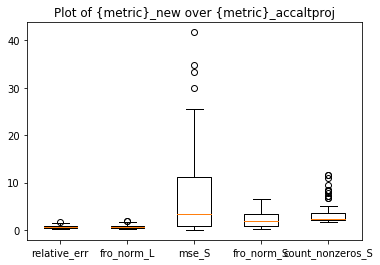

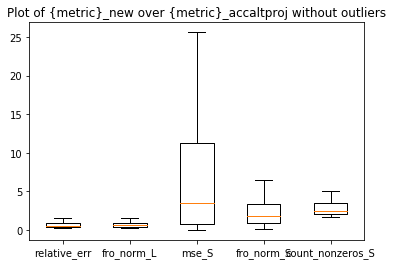

relative_err: 1/100 outliers
fro_norm_L: 2/100 outliers
mse_S: 4/100 outliers
fro_norm_S: 0/100 outliers
count_nonzeros_S: 12/100 outliers


In [169]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [171]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.6771621974959865e-18
fro_norm_L:  2.9668837609981906e-13
mse_S:  0.9999999999436217
fro_norm_S:  0.9999999999994206
count_nonzeros_S:  1.0


<p style="color:blue;"> Same as the case when trained on accaltproj, S from unrolled isn't as good as accaltproj. </p>

### Scenario 4:
**alpha = 0.1** (higher sparsity), **c = 10**, r = 2, dimension = 250x250

gamma=6.866e-01; beta=1.427e-02

***results: for S, mean and sd improved, but ratio _new/_old harder to interpret. For L, performance from unrolled is better than AccAltproj but not IRCUR.***

In [104]:
## ======================== 0. set constants ========================
d1 = 250                   # num. of rows
d2 = 250                   # num. of columns
max_iter = 40              # num. of layers trained
alpha_true = 0.1
c_true = 10
r = 2
dataset_size = 1000

## ======================== 1. generate data ========================
train4, test4 =  generate_train_test(dataset_size, r, d1, d2, alpha_true, c_true)

train dataset size: 900
test dataset size: 100


#### Training

In [105]:
## ======================== 2. estimations by classical ========================
train_est4 = []
for i, (L_true, S_true, M_true) in enumerate(train4):
    loss, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, max_iter)
    train_est4.append((L0, S0, M_true))

In [106]:
## ======================== 3. train unrolled network with estimated data ========================
net4, params_bftrain4, params_aftrain4, l0_norm_of_S_Shat4 = train_nn(LearnedAAP(max_iter), r \
                                                                    , lr=2e-04, weight_decay=0 \
                                                                    , nepochs=100, dataset=train_est4)

[Parameter containing:
tensor(6.983e-01, requires_grad=True), Parameter containing:
tensor(2.825e-02, requires_grad=True)]
Epoch 1/100 at cost=3.756600108317798e-06
[Parameter containing:
tensor(6.967e-01, requires_grad=True), Parameter containing:
tensor(2.667e-02, requires_grad=True)]
Epoch 2/100 at cost=3.715257207659306e-06
[Parameter containing:
tensor(6.952e-01, requires_grad=True), Parameter containing:
tensor(2.519e-02, requires_grad=True)]
Epoch 3/100 at cost=3.7047580008220393e-06
[Parameter containing:
tensor(6.940e-01, requires_grad=True), Parameter containing:
tensor(2.387e-02, requires_grad=True)]
Epoch 4/100 at cost=3.6947326407243963e-06
[Parameter containing:
tensor(6.929e-01, requires_grad=True), Parameter containing:
tensor(2.273e-02, requires_grad=True)]
Epoch 5/100 at cost=3.707594714796869e-06
[Parameter containing:
tensor(6.920e-01, requires_grad=True), Parameter containing:
tensor(2.167e-02, requires_grad=True)]
Epoch 6/100 at cost=3.6487990655587055e-06
[Parame

#### Evaluating unrolled network on train dataset

In [107]:
out_bftrain4, out_hat4 = get_net_outputs(net4, LearnedAAP(max_iter), r, train4)
out_accaltproj4 = []
for i, (L_true, S_true, M_true) in enumerate(train4):
    loss, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), max_iter)
    out_accaltproj4.append((L0, S0))

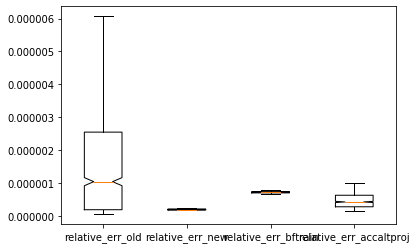

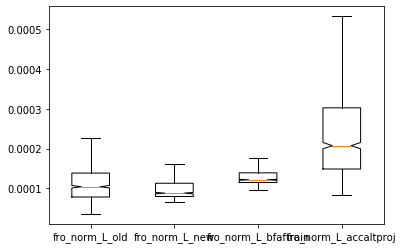

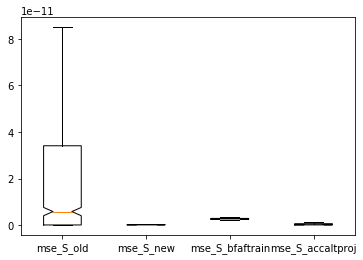

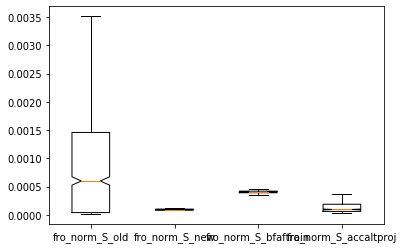

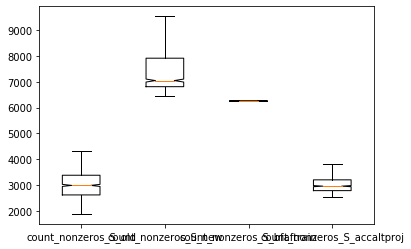

In [125]:
metrics = get_metrics(train4, [x[:2] for x in train_est4], out_bftrain4, out_hat4)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(train4, out_accaltproj4, out_bftrain4, out_hat4).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, \
    relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["relative_err_old", \
    "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True, showfliers=False)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [109]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  1.0353532603942041e-78
fro_norm_L_new, fro_norm_L_old:  2.5524118133551505e-08
mse_S_new, mse_S_old:  1.2958493942867375e-25
fro_norm_S_new, fro_norm_S_old:  4.9741229347689466e-77
count_nonzeros_S_new, count_nonzeros_S_old:  1.0

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  1.7262844306945216e-171
fro_norm_L_new, fro_norm_L_accaltproj:  2.0891449758038464e-158
mse_S_new, mse_S_accaltproj:  8.145269461552827e-38
fro_norm_S_new, fro_norm_S_accaltproj:  1.3737945088307955e-32
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  1.0

relative_err_new, relative_err_bftrain:  0.0
fro_norm_L_new, fro_norm_L_bftrain:  1.056421569351547e-74
mse_S_new, mse_S_bftrain:  0.0
fro_norm_S_new, fro_norm_S_bftrain:  0.0
count_nonzeros_S_new, count_nonzeros_S_bftrain:  1.0


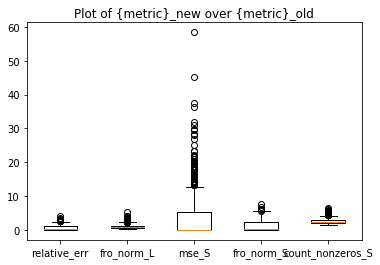

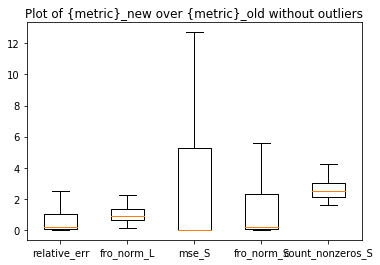

relative_err: 9/900 outliers
fro_norm_L: 41/900 outliers
mse_S: 65/900 outliers
fro_norm_S: 5/900 outliers
count_nonzeros_S: 45/900 outliers


In [110]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [111]:
print("P-values from test of mean with H1: _new/_old < 1")
print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
*Note: values are log-transformed before deriving p-values 

relative_err:  4.0827102883927394e-132
fro_norm_L:  7.17518670565087e-05
mse_S:  1.2449084361781714e-73
fro_norm_S:  1.2449266318284768e-73
count_nonzeros_S:  1.0


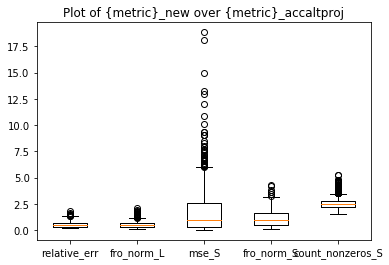

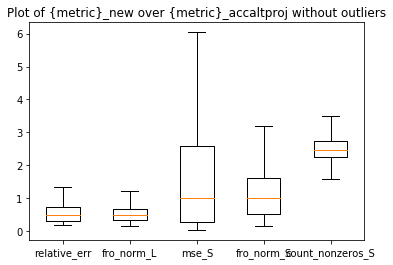

relative_err: 8/900 outliers
fro_norm_L: 37/900 outliers
mse_S: 43/900 outliers
fro_norm_S: 7/900 outliers
count_nonzeros_S: 97/900 outliers


In [112]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [113]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.0915149451837567e-250
fro_norm_L:  1.7195883404605009e-239
mse_S:  1.0
fro_norm_S:  0.999998143864941
count_nonzeros_S:  1.0


#### Evaluating unrolled network on test dataset

In [114]:
out_bftrain_ontest4, out_hat_ontest4 = get_net_outputs(net4, LearnedAAP(max_iter), r, test4)
out_accaltproj_ontest4 = []
out_ircur_ontest4 = []
for (L_true, S_true, M_true) in test4:
    loss0, L0, S0 = AccAltProj(M_true, r, 1e-06, torch.tensor(0.7), 40)
    out_accaltproj_ontest4.append((L0, S0))
    loss0, L0, S0 = IRCUR(M_true, r, 1e-06, torch.tensor(0.7), 3, 40)
    out_ircur_ontest4.append((L0, S0))

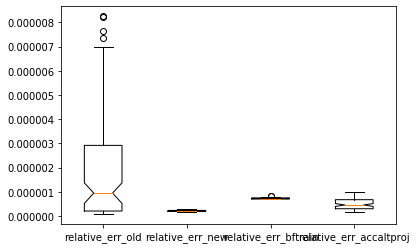

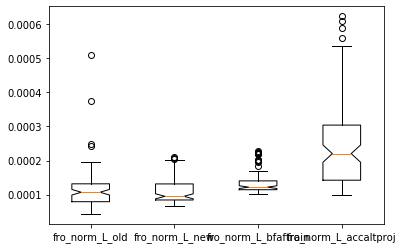

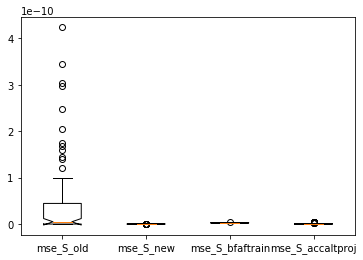

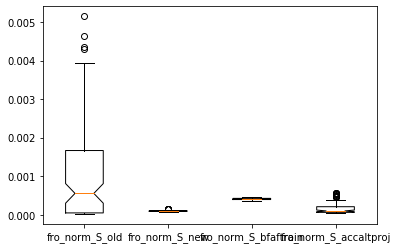

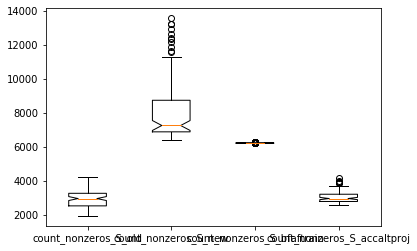

In [126]:
metrics = get_metrics(test4, out_ircur_ontest4, out_bftrain_ontest4, out_hat_ontest4)
fro_norm_L_old, mse_S_old, fro_norm_S_old, count_nonzeros_S_old, relative_err_old, \
    fro_norm_L_new, mse_S_new, fro_norm_S_new, count_nonzeros_S_new, relative_err_new, \
    fro_norm_L_bftrain, mse_S_bftrain, fro_norm_S_bftrain, count_nonzeros_S_bftrain, relative_err_bftrain \
        = metrics.values()
fro_norm_L_accaltproj, mse_S_accaltproj, fro_norm_S_accaltproj, count_nonzeros_S_accaltproj, relative_err_accaltproj \
    = list(get_metrics(test4, out_accaltproj_ontest4, out_bftrain_ontest4, out_hat_ontest4).values())[:5]

fig, ax = plt.subplots()
ax.boxplot([relative_err_old, relative_err_new, relative_err_bftrain, relative_err_accaltproj], notch = True)
ax.set_xticklabels(["relative_err_old", "relative_err_new", "relative_err_bftrain", "relative_err_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_L_old, fro_norm_L_new, fro_norm_L_bftrain, fro_norm_L_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_L_old", "fro_norm_L_new", "fro_norm_L_bfaftrain", "fro_norm_L_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([mse_S_old, mse_S_new, mse_S_bftrain, mse_S_accaltproj], notch = True)
ax.set_xticklabels(["mse_S_old", "mse_S_new", "mse_S_bfaftrain", "mse_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([fro_norm_S_old, fro_norm_S_new, fro_norm_S_bftrain, fro_norm_S_accaltproj], notch = True)
ax.set_xticklabels(["fro_norm_S_old", "fro_norm_S_new", "fro_norm_S_bfaftrain", "fro_norm_S_accaltproj"])
plt.show()

fig, ax = plt.subplots()
ax.boxplot([count_nonzeros_S_old, count_nonzeros_S_new, count_nonzeros_S_bftrain, count_nonzeros_S_accaltproj], notch = True)
ax.set_xticklabels(["count_nonzeros_S_old", "count_nonzeros_S_new", "count_nonzeros_S_bfaftrain", "count_nonzeros_S_accaltproj"])
plt.show()

In [116]:
print("P-values from test of mean with H1: _new < _old")
print("relative_err_new, relative_err_old: ", stats.ttest_rel(relative_err_new, relative_err_old, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_old, alternative='less').pvalue)
print("mse_S_new, mse_S_old: ", stats.ttest_rel(mse_S_new, mse_S_old, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_old, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_old, alternative='less').pvalue)
print()
print("P-values from test of mean with H1: _new < _accaltproj")
print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(relative_err_new, relative_err_accaltproj, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_accaltproj, alternative='less').pvalue)
print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(mse_S_new, mse_S_accaltproj, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_accaltproj, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_accaltproj, alternative='less').pvalue)
print()
print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(relative_err_new, relative_err_bftrain, alternative='less').pvalue)
print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(fro_norm_L_new, fro_norm_L_bftrain, alternative='less').pvalue)
print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(mse_S_new, mse_S_bftrain, alternative='less').pvalue)
print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(fro_norm_S_new, fro_norm_S_bftrain, alternative='less').pvalue)
print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(count_nonzeros_S_new, count_nonzeros_S_bftrain, alternative='less').pvalue)

# print("*Note: values are log-transformed before deriving p-values")
# print()
# print("relative_err_new, relative_err_old: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_old), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_old: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_old), alternative='less').pvalue)
# print("mse_S_new, mse_S_old: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_old), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_old: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_old), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_old: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_old), alternative='less').pvalue)
# print()
# print("P-values from test of mean with H1: _new < _accaltproj")
# print("relative_err_new, relative_err_accaltproj: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_accaltproj), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_accaltproj: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_accaltproj), alternative='less').pvalue)
# print("mse_S_new, mse_S_accaltproj: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_accaltproj), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_accaltproj: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_accaltproj), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_accaltproj: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_accaltproj), alternative='less').pvalue)
# print()
# print("relative_err_new, relative_err_bftrain: ", stats.ttest_rel(np.log(relative_err_new), np.log(relative_err_bftrain), alternative='less').pvalue)
# print("fro_norm_L_new, fro_norm_L_bftrain: ", stats.ttest_rel(np.log(fro_norm_L_new), np.log(fro_norm_L_bftrain), alternative='less').pvalue)
# print("mse_S_new, mse_S_bftrain: ", stats.ttest_rel(np.log(mse_S_new), np.log(mse_S_bftrain), alternative='less').pvalue)
# print("fro_norm_S_new, fro_norm_S_bftrain: ", stats.ttest_rel(np.log(fro_norm_S_new), np.log(fro_norm_S_bftrain), alternative='less').pvalue)
# print("count_nonzeros_S_new, count_nonzeros_S_bftrain: ", stats.ttest_rel(np.log(count_nonzeros_S_new), np.log(count_nonzeros_S_bftrain), alternative='less').pvalue)

P-values from test of mean with H1: _new < _old
relative_err_new, relative_err_old:  1.3586581621281825e-12
fro_norm_L_new, fro_norm_L_old:  0.4407910889492411
mse_S_new, mse_S_old:  3.653334066352464e-07
fro_norm_S_new, fro_norm_S_old:  3.1921084285662314e-12
count_nonzeros_S_new, count_nonzeros_S_old:  1.0

P-values from test of mean with H1: _new < _accaltproj
relative_err_new, relative_err_accaltproj:  4.943374368833945e-20
fro_norm_L_new, fro_norm_L_accaltproj:  8.555932956170981e-17
mse_S_new, mse_S_accaltproj:  4.817612479848941e-06
fro_norm_S_new, fro_norm_S_accaltproj:  1.59564360530666e-05
count_nonzeros_S_new, count_nonzeros_S_accaltproj:  1.0

relative_err_new, relative_err_bftrain:  2.609585096473376e-117
fro_norm_L_new, fro_norm_L_bftrain:  1.4876966067392613e-06
mse_S_new, mse_S_bftrain:  2.2439106006223737e-96
fro_norm_S_new, fro_norm_S_bftrain:  2.853534318692783e-115
count_nonzeros_S_new, count_nonzeros_S_bftrain:  1.0


<p style="color:blue;"> Performance better than AccAltproj but not IRCUR for L. </p>

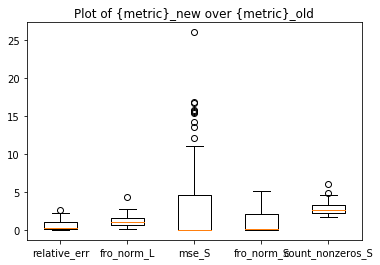

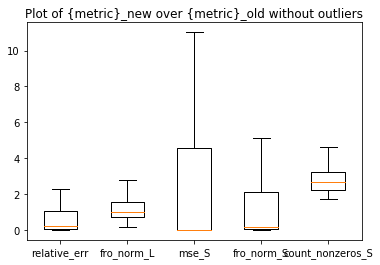

relative_err: 1/100 outliers
fro_norm_L: 1/100 outliers
mse_S: 10/100 outliers
fro_norm_S: 0/100 outliers
count_nonzeros_S: 2/100 outliers


In [127]:
relative_err = np.array([relative_err_new[i]/ relative_err_old[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_old[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_old[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_old[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_old[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_old without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [118]:
print("P-values from test of mean with H1: _new/_old < 1")
print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_old < 1
*Note: values are log-transformed before deriving p-values 

relative_err:  9.82235613096424e-17
fro_norm_L:  0.7679409143412552
mse_S:  1.0989935009245609e-10
fro_norm_S:  1.0989942427317515e-10
count_nonzeros_S:  1.0


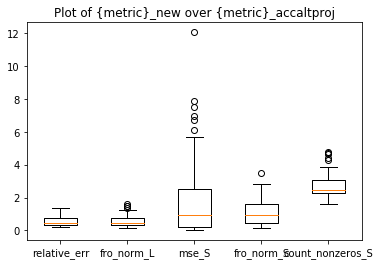

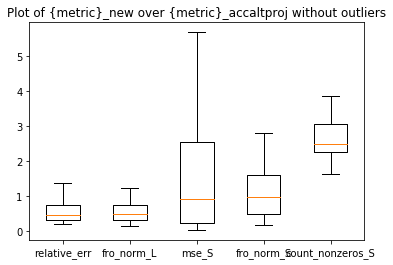

relative_err: 0/100 outliers
fro_norm_L: 4/100 outliers
mse_S: 6/100 outliers
fro_norm_S: 1/100 outliers
count_nonzeros_S: 5/100 outliers


In [128]:
relative_err = np.array([relative_err_new[i]/ relative_err_accaltproj[i] for i in range(len(relative_err_new))])
fro_norm_L = np.array([fro_norm_L_new[i]/ fro_norm_L_accaltproj[i] for i in range(len(fro_norm_L_new))])
mse_S = np.array([mse_S_new[i]/ mse_S_accaltproj[i] for i in range(len(mse_S_new))])
fro_norm_S = np.array([fro_norm_S_new[i]/ fro_norm_S_accaltproj[i] for i in range(len(fro_norm_S_new))])
count_nonzeros_S = np.array([count_nonzeros_S_new[i]/ count_nonzeros_S_accaltproj[i] for i in range(len(count_nonzeros_S_new))])
d = {"relative_err": relative_err \
    , "fro_norm_L": fro_norm_L \
    , "mse_S": mse_S \
    , "fro_norm_S": fro_norm_S \
    , "count_nonzeros_S": count_nonzeros_S
    }

fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj")
plt.show()

fig, ax = plt.subplots()
ax.boxplot(d.values(), showfliers=False)
ax.set_xticklabels(d.keys())
ax.set_title("Plot of {metric}_new over {metric}_accaltproj without outliers")
plt.show()

for key, val in d.items():
    print(f"{key}: {count_outliers(d[key])}/{len(relative_err)} outliers")

In [129]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
#print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(val, 1, alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
relative_err:  1.0211019655144017e-27
fro_norm_L:  2.9200413736276013e-23
mse_S:  0.9996789456360078
fro_norm_S:  0.9066114814325372
count_nonzeros_S:  1.0


In [130]:
print("P-values from test of mean with H1: _new/_accaltproj < 1")
print("*Note: values are log-transformed before deriving p-values \n")
for key, val in d.items():
    print(f'{key}: ', stats.ttest_1samp(np.log(val), np.log(1), alternative='less').pvalue)

P-values from test of mean with H1: _new/_accaltproj < 1
*Note: values are log-transformed before deriving p-values 

relative_err:  1.1374669575391843e-24
fro_norm_L:  4.1581425521605883e-22
mse_S:  0.012984830040341986
fro_norm_S:  0.012984871940837217
count_nonzeros_S:  1.0


<p style="color:blue;"> Performance better than AccAltproj but not IRCUR for L. </p>